# Hands-on time

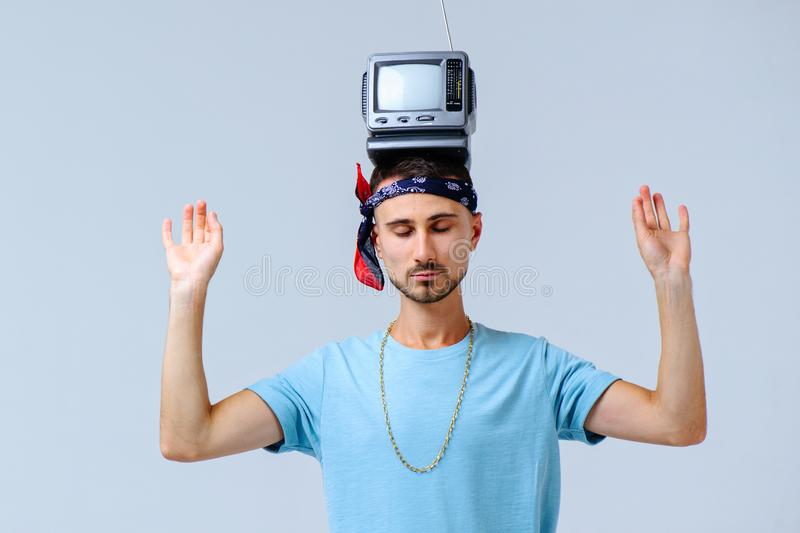

In this lab we'll follow the next steps:
1. Downnload data using Yahoo Finance API
2. Explore and analyze data
3. Learn how to deal with forecasting models - Prophet

In [ ]:
# *IMPORT LIBRARIES USED*

!pip install prophet
!pip install yfinance

from prophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

**yfinance**

"Ever since Yahoo! finance decommissioned their historical data API, many programs that relied on it to stop working.

yfinance aimes to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance."

https://pypi.org/project/yfinance/

# 1. Download data

Definition of an analysis starting and ending period

In [ ]:
start = pd.to_datetime('2010-01-01')
end = date.today()
#custom_end = pd.to_datetime('2022-05-22')
#end = custom_end

Definition of a list of Ticker: in yfinance you need to specify the rate needed in the following format:  't_currency1t_currency2=X'.

In [ ]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

Download the previous tickers only for Close prices

In [ ]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
forex_df

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-01      1.438994      1.613294       1.03390     92.919998   
2010-01-04      1.442398      1.611370       1.02910     92.495003   
2010-01-05      1.436596      1.599079       1.03370     91.584999   
2010-01-06      1.440403      1.602384       1.02760     92.356003   
2010-01-07      1.431803      1.593397       1.03360     93.389999   
...                  ...           ...           ...           ...   
2024-05-24      1.081268      1.269406       0.91433    156.973007   
2024-05-27      1.084763      1.273610       0.91440    156.869995   
2024-05-28      1.086189      1.277237       0.91320    156.845001   
2024-05-29      1.085187      1.275836       0.91229    157.261993   
2024-05-30      1.080182      1.269799       0.91280    157.608002   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-01    133.710007       1.05120      0.898473  
2010-01-04    133.389999       1.04100      0.912492  
2010-01-05    131.529999       1.03950      0.911826  
2010-01-06    133.013000       1.03190      0.920471  
2010-01-07    133.748001       1.03400      0.917768  
...                  ...           ...           ...  
2024-05-24    169.714005       1.37321      0.660149  
2024-05-27    170.160995       1.36660      0.662401  
2024-05-28    170.347000       1.36289      0.665562  
2024-05-29    170.654007       1.36460      0.664800  
2024-05-30    170.216003       1.37170      0.661370  

[3758 rows x 7 columns]

# 2. Data exploration

### Check missing values and fill if needed

In [ ]:
# nan values do exist
forex_df[forex_df.isnull().any(axis=1)]

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2011-04-15      1.443210           NaN           NaN           NaN   
2012-01-27      1.309278      1.568209           NaN     77.459999   
2012-01-31      1.313957      1.570845           NaN     76.360001   
2012-12-04           NaN      1.609787           NaN     82.133003   
2013-10-08           NaN           NaN           NaN           NaN   
2019-05-22           NaN           NaN           NaN           NaN   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2011-04-15           NaN           NaN           NaN  
2012-01-27    101.421997        1.0024      1.061582  
2012-01-31    100.330002        1.0024      1.058604  
2012-12-04    107.301003           NaN           NaN  
2013-10-08    131.289993           NaN           NaN  
2019-05-22    123.438004           NaN           NaN

Multiple strategies can be used to fill missing values, these depend on the nature of the problem (but be aware of the consequences):

- use median, mode, mean values
- use a statistical method: regression, nearest neighbors
- back/forward fill, **interpolate**
- drop missing data

In [ ]:
# fillna fills with given value or method: in this case forward fill
forex_df.fillna(method='ffill', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-15 00:00:00, dtype: float64

In [ ]:
forex_df.loc['2011-04-14']

eurusd_close      1.444210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-14 00:00:00, dtype: float64

In [ ]:
# interpolate interpolates given a method
forex_df.interpolate(method='linear', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.629145
usdchf_close      0.894250
usdjpy_close     83.465000
eurjpy_close    120.417999
usdcad_close      0.961300
audusd_close      1.053002
Name: 2011-04-15 00:00:00, dtype: float64

In [ ]:
forex_df.loc[['2011-04-14', '2011-04-15', '2011-04-18']]

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2011-04-14      1.444210      1.626889        0.8959     83.782997   
2011-04-15      1.443210           NaN           NaN           NaN   
2011-04-18      1.441296      1.631401        0.8926     83.147003   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2011-04-14    121.000000        0.9626      1.049803  
2011-04-15           NaN           NaN           NaN  
2011-04-18    119.835999        0.9600      1.056201

In [ ]:
# let's use interpolation since we are dealing with time series data
forex_df.interpolate(method='linear', axis=0, inplace=True)
# double check on missing data
forex_df[forex_df.isnull().any(axis=1)]

Empty DataFrame
Columns: [eurusd_close, gbpusd_close, usdchf_close, usdjpy_close, eurjpy_close, usdcad_close, audusd_close]
Index: []

In [ ]:
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3758 entries, 2010-01-01 to 2024-05-30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eurusd_close  3758 non-null   float64
 1   gbpusd_close  3758 non-null   float64
 2   usdchf_close  3758 non-null   float64
 3   usdjpy_close  3758 non-null   float64
 4   eurjpy_close  3758 non-null   float64
 5   usdcad_close  3758 non-null   float64
 6   audusd_close  3758 non-null   float64
dtypes: float64(7)
memory usage: 363.9 KB


In [ ]:
forex_df.describe()

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  eurjpy_close  \
count   3758.000000   3758.000000   3758.000000   3758.000000   3758.000000   
mean       1.194602      1.415201      0.949549    108.448536    127.868728   
std        0.114136      0.152325      0.051314     18.597321     14.262730   
min        0.959619      1.072754      0.722800     75.739998     94.209999   
25%        1.101904      1.280201      0.914040     98.936249    119.501251   
50%        1.165101      1.380586      0.950000    108.883999    128.345497   
75%        1.299018      1.561768      0.984515    115.458500    135.539494   
max        1.484406      1.716090      1.162700    158.223999    170.654007   

       usdcad_close  audusd_close  
count   3758.000000   3758.000000  
mean       1.212944      0.807525  
std        0.140525      0.131480  
min        0.943200      0.574290  
25%        1.049060      0.708908  
50%        1.272980      0.759413  
75%        1.326667      0.921150  
max        1.457800      1.103497

### Visualize data

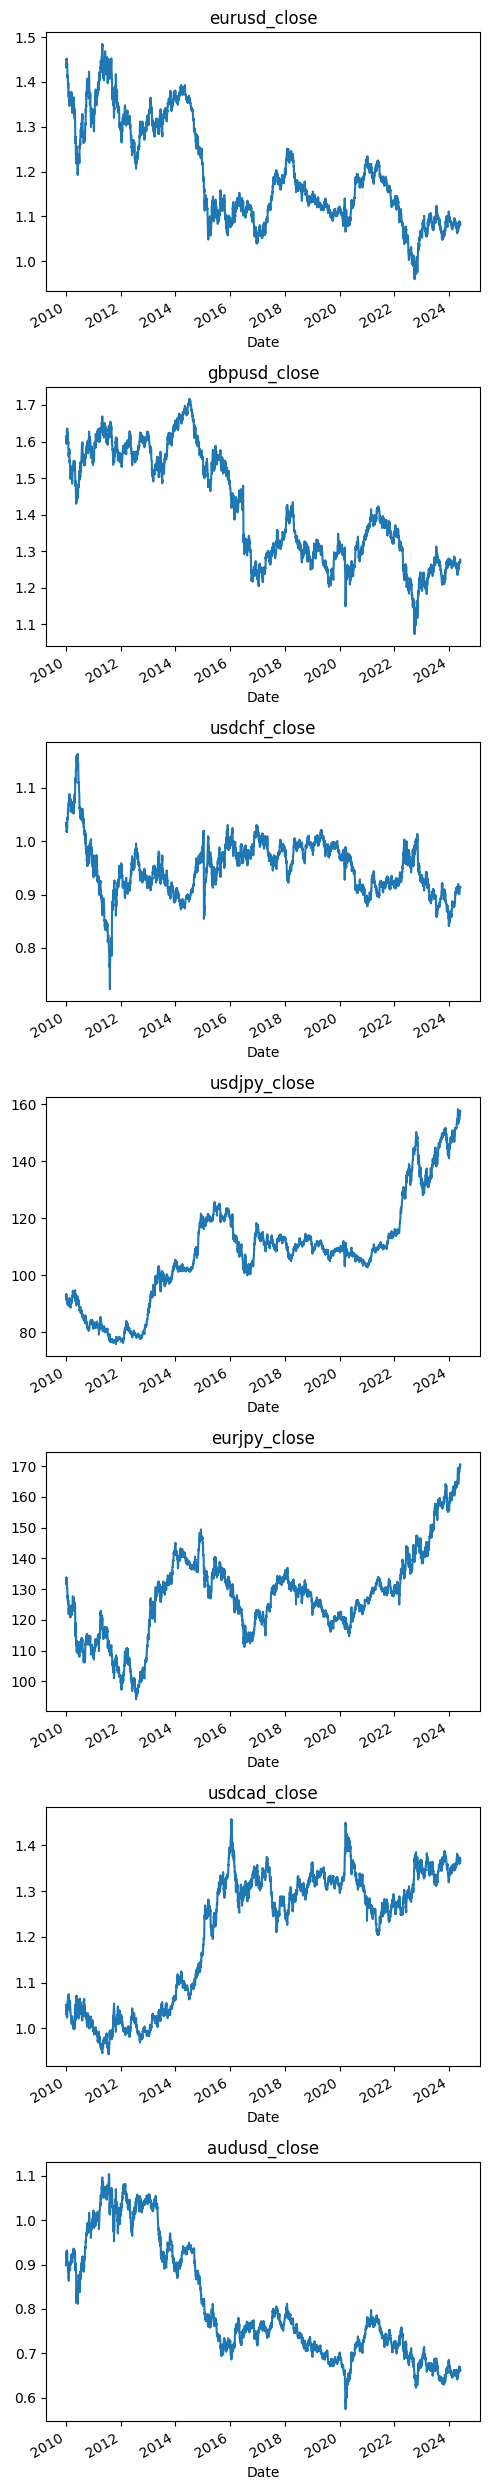

In [ ]:
fig, ax = plt.subplots(forex_df.shape[1],1, figsize=(5,25))
for idx, col in enumerate(forex_df):
  forex_df[col].plot(ax=ax[idx])
  ax[idx].set_title(col)
fig.tight_layout()

In [ ]:
# Looking for something fancier? go for plotly :-)

for idx, col in enumerate(forex_df):
  fig = px.line(forex_df, y=col)
  fig.show()

Scaling the changes using by percentange change, in order to remove differences between pricing, scaling is also vital to perform the Value at Risk calculation and for a statistical analysis.

1. For risk analysis we are more interested in daily changes than in the absolute value of the rate. (e.g. for VaR analysis)

In [ ]:
forex_rate_df = forex_df.pct_change(axis='rows')
forex_rate_df_clean = forex_rate_df.dropna(axis=0)

In [ ]:
# New Dataframe cleaned
forex_rate_df_clean

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-04      0.002366     -0.001192     -0.004643     -0.004574   
2010-01-05     -0.004022     -0.007628      0.004470     -0.009838   
2010-01-06      0.002650      0.002067     -0.005901      0.008418   
2010-01-07     -0.005971     -0.005609      0.005839      0.011196   
2010-01-08      0.006499      0.005657     -0.009675     -0.007817   
...                  ...           ...           ...           ...   
2024-05-24     -0.001157     -0.002120     -0.000732      0.001717   
2024-05-27      0.003233      0.003311      0.000077     -0.000656   
2024-05-28      0.001314      0.002848     -0.001312     -0.000159   
2024-05-29     -0.000922     -0.001097     -0.000997      0.002659   
2024-05-30     -0.004612     -0.004731      0.000559      0.002200   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-04     -0.002393     -0.009703      0.015604  
2010-01-05     -0.013944     -0.001441     -0.000729  
2010-01-06      0.011275     -0.007311      0.009481  
2010-01-07      0.005526      0.002035     -0.002937  
2010-01-08     -0.001929     -0.004062      0.007956  
...                  ...           ...           ...  
2024-05-24      0.000483      0.003149     -0.002674  
2024-05-27      0.002634     -0.004813      0.003411  
2024-05-28      0.001093     -0.002715      0.004772  
2024-05-29      0.001802      0.001255     -0.001145  
2024-05-30     -0.002567      0.005203     -0.005159  

[3757 rows x 7 columns]

Aggregated Returns plot

In [ ]:
fig = go.Figure()

for ticker in forex_rate_df_clean.columns:

  # Only thing I figured is - I could do this
  fig.add_scatter(
                  x=forex_rate_df_clean.index,
                  y=forex_rate_df_clean[f'{ticker}'],
                  name=f'{ticker}'
                ) # Not what is desired - need a line

# Show plot
fig.show()

### Standard Deviation of the different rates of returns.

In [ ]:
for ticker in forex_rate_df_clean.columns:
  fig = px.histogram(forex_rate_df_clean, x=ticker,
                    marginal="rug", template="plotly_white",
                    hover_data=forex_rate_df_clean.columns,
                    title=f'Distribution of {ticker} the std related to it is {np.round(forex_rate_df_clean[ticker].std(), 3)}')
  fig.show()

Correlation analysis between numerical variables.

In [ ]:
fig = px.scatter_matrix(forex_rate_df_clean,
                        dimensions=forex_rate_df_clean.columns.to_list(),
                        height=1000, width=1000,
                        template='plotly_white'
                        )

fig.update_traces(diagonal_visible=False)
fig.show()

### Pearson Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

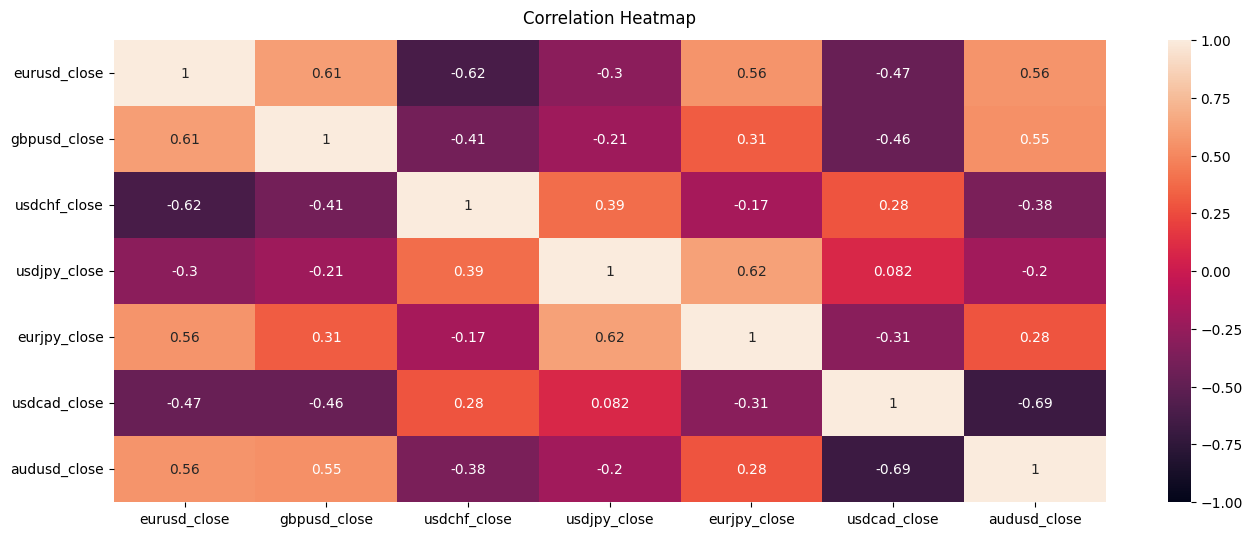

In [ ]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(forex_rate_df_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# 3. Forecasting Method - Prophet

Prophet is a library developed by Facebook for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well (Facebook-Prophet website: https://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,daily%20seasonality%2C%20plus%20holiday%20effects.&text=Prophet%20is%20open%20source%20software,download%20on%20CRAN%20and%20PyPI.)

In order to forecast the SINGLE series in the future we need to:
1. ALWAYS add an additional column related to the y variable (in our scenario equal to eurgbp_close) to df['y']
2. ALWAYS Reset the index of the series and rename the column with the date in df['ds']

In [ ]:
forex_df

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-01      1.438994      1.613294       1.03390     92.919998   
2010-01-04      1.442398      1.611370       1.02910     92.495003   
2010-01-05      1.436596      1.599079       1.03370     91.584999   
2010-01-06      1.440403      1.602384       1.02760     92.356003   
2010-01-07      1.431803      1.593397       1.03360     93.389999   
...                  ...           ...           ...           ...   
2024-05-24      1.081268      1.269406       0.91433    156.973007   
2024-05-27      1.084763      1.273610       0.91440    156.869995   
2024-05-28      1.086189      1.277237       0.91320    156.845001   
2024-05-29      1.085187      1.275836       0.91229    157.261993   
2024-05-30      1.080182      1.269799       0.91280    157.608002   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-01    133.710007       1.05120      0.898473  
2010-01-04    133.389999       1.04100      0.912492  
2010-01-05    131.529999       1.03950      0.911826  
2010-01-06    133.013000       1.03190      0.920471  
2010-01-07    133.748001       1.03400      0.917768  
...                  ...           ...           ...  
2024-05-24    169.714005       1.37321      0.660149  
2024-05-27    170.160995       1.36660      0.662401  
2024-05-28    170.347000       1.36289      0.665562  
2024-05-29    170.654007       1.36460      0.664800  
2024-05-30    170.216003       1.37170      0.661370  

[3758 rows x 7 columns]

In [ ]:
# In order to forecast the series we need to: 1.
# 1)
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values

forex_df.tail()

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2024-05-24      1.081268      1.269406       0.91433    156.973007   
2024-05-27      1.084763      1.273610       0.91440    156.869995   
2024-05-28      1.086189      1.277237       0.91320    156.845001   
2024-05-29      1.085187      1.275836       0.91229    157.261993   
2024-05-30      1.080182      1.269799       0.91280    157.608002   

            eurjpy_close  usdcad_close  audusd_close         ds         y  
Date                                                                       
2024-05-24    169.714005       1.37321      0.660149 2024-05-24  1.081268  
2024-05-27    170.160995       1.36660      0.662401 2024-05-27  1.084763  
2024-05-28    170.347000       1.36289      0.665562 2024-05-28  1.086189  
2024-05-29    170.654007       1.36460      0.664800 2024-05-29  1.085187  
2024-05-30    170.216003       1.37170      0.661370 2024-05-30  1.080182

Create train and test, test used in prophet only for backtesting reason!

In [ ]:
# define test and train window
train_window =  ['2010-01-03','2020-10-31']
test_window =  ['2020-11-01','2021-06-10']

In [ ]:
# create train and test dataset
train = forex_df[train_window[0]:train_window[1]]
test = forex_df[test_window[0]:test_window[1]]


In [ ]:
train

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-04      1.442398      1.611370      1.029100     92.495003   
2010-01-05      1.436596      1.599079      1.033700     91.584999   
2010-01-06      1.440403      1.602384      1.027600     92.356003   
2010-01-07      1.431803      1.593397      1.033600     93.389999   
2010-01-08      1.441109      1.602410      1.023600     92.660004   
...                  ...           ...           ...           ...   
2020-10-26      1.184848      1.305466      0.904560    104.682999   
2020-10-27      1.180944      1.301575      0.907900    104.832001   
2020-10-28      1.178411      1.303186      0.908875    104.544998   
2020-10-29      1.174867      1.298988      0.910590    104.315002   
2020-10-30      1.167870      1.293193      0.915310    104.554001   

            eurjpy_close  usdcad_close  audusd_close         ds         y  
Date                                                                       
2010-01-04    133.389999       1.04100      0.912492 2010-01-04  1.442398  
2010-01-05    131.529999       1.03950      0.911826 2010-01-05  1.436596  
2010-01-06    133.013000       1.03190      0.920471 2010-01-06  1.440403  
2010-01-07    133.748001       1.03400      0.917768 2010-01-07  1.431803  
2010-01-08    133.490005       1.02980      0.925069 2010-01-08  1.441109  
...                  ...           ...           ...        ...       ...  
2020-10-26    124.035004       1.31472      0.713201 2020-10-26  1.184848  
2020-10-27    123.796997       1.32061      0.711710 2020-10-27  1.180944  
2020-10-28    123.169998       1.31918      0.712310 2020-10-28  1.178411  
2020-10-29    122.550003       1.33105      0.705520 2020-10-29  1.174867  
2020-10-30    122.103996       1.33153      0.703760 2020-10-30  1.167870  

[2823 rows x 9 columns]

In [ ]:
m = Prophet()
m.fit(train[['ds', 'y']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu_akp3dy/rfipdu8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu_akp3dy/yk5tktag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36691', 'data', 'file=/tmp/tmpu_akp3dy/rfipdu8y.json', 'init=/tmp/tmpu_akp3dy/yk5tktag.json', 'output', 'file=/tmp/tmpu_akp3dy/prophet_modelb5lwxf_c/prophet_model-20240531153639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:36:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(20, freq='B')

In [ ]:
future

ds
0    2010-01-04
1    2010-01-05
2    2010-01-06
3    2010-01-07
4    2010-01-08
...         ...
2838 2020-11-23
2839 2020-11-24
2840 2020-11-25
2841 2020-11-26
2842 2020-11-27

[2843 rows x 1 columns]

In [ ]:
future = m.make_future_dataframe(20, freq='B') # Explain B with https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
forecast = m.predict(future)

forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)
forecast_results.set_index('ds', inplace=True)

In [ ]:
forecast_results

yhat  yhat_lower  yhat_upper
ds                                          
2020-11-02  1.134049    1.105305    1.164123
2020-11-03  1.132752    1.104391    1.162238
2020-11-04  1.131420    1.102365    1.161784
2020-11-05  1.130057    1.102479    1.158592
2020-11-06  1.128765    1.099371    1.156502
2020-11-09  1.124468    1.097170    1.151748
2020-11-10  1.123184    1.095012    1.151902
2020-11-11  1.121960    1.094235    1.151518
2020-11-12  1.120798    1.091845    1.149517
2020-11-13  1.119797    1.092309    1.146826
2020-11-16  1.116856    1.086605    1.146145
2020-11-17  1.116160    1.086521    1.145058
2020-11-18  1.115577    1.086854    1.144349
2020-11-19  1.115098    1.089094    1.142734
2020-11-20  1.114810    1.086039    1.142314
2020-11-23  1.114075    1.085443    1.144268
2020-11-24  1.114097    1.083850    1.141756
2020-11-25  1.114204    1.085416    1.143698
2020-11-26  1.114377    1.084341    1.141387
2020-11-27  1.114694    1.086604    1.142690

In [ ]:
final_df_results = pd.merge(test[['eurusd_close']], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')

In [ ]:
final_df_results

eurusd_close      yhat
2020-11-02      1.164212  1.134049
2020-11-03      1.164280  1.132752
2020-11-04      1.176221  1.131420
2020-11-05      1.173268  1.130057
2020-11-06      1.181754  1.128765
2020-11-09      1.189301  1.124468
2020-11-10      1.182732  1.123184
2020-11-11      1.181879  1.121960
2020-11-12      1.178030  1.120798
2020-11-13      1.180339  1.119797
2020-11-16      1.184525  1.116856
2020-11-17      1.185944  1.116160
2020-11-18      1.186366  1.115577
2020-11-19      1.184764  1.115098
2020-11-20      1.186648  1.114810
2020-11-23      1.186648  1.114075
2020-11-24      1.184273  1.114097
2020-11-25      1.190051  1.114204
2020-11-26      1.192000  1.114377
2020-11-27      1.191600  1.114694

## Model evaluation and scores

In [ ]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae https://en.wikipedia.org/wiki/Mean_absolute_error
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse https://en.wikipedia.org/wiki/Root-mean-square_deviation
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias https://en.wikipedia.org/wiki/Bias_(statistics)
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()


Mean MAE: 0.06
MAE%: 5.19%
RMSE: 0.06
Bias: -0.06

5th percetile MAE: 0.03
25th percetile MAE: 0.06
50th percetile MAE: 0.07
75th percetile MAE: 0.07
95th percetile MAE: 0.08


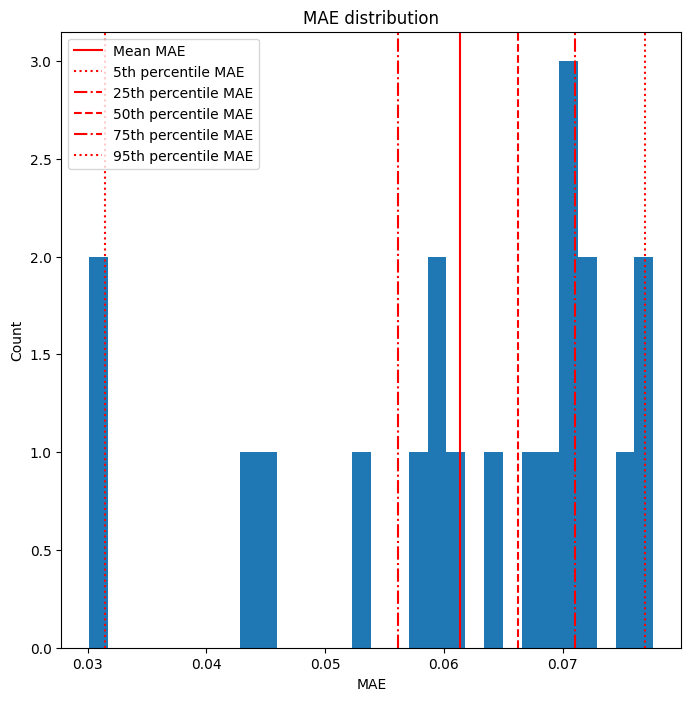

In [ ]:
# Analyze the forecast error
calc_errors(final_df_results['eurusd_close'].values, final_df_results['yhat'].values)


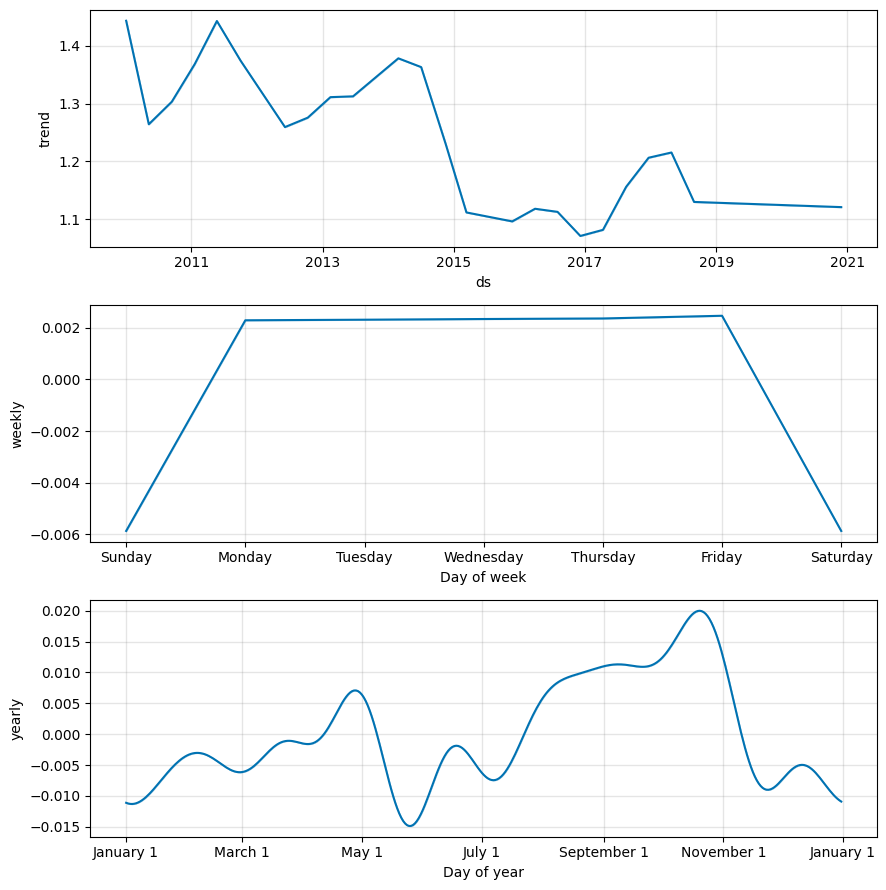

In [ ]:
# explore the components of the fitted model
fig = m.plot_components(forecast)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

### Short long story: work hard for nothing

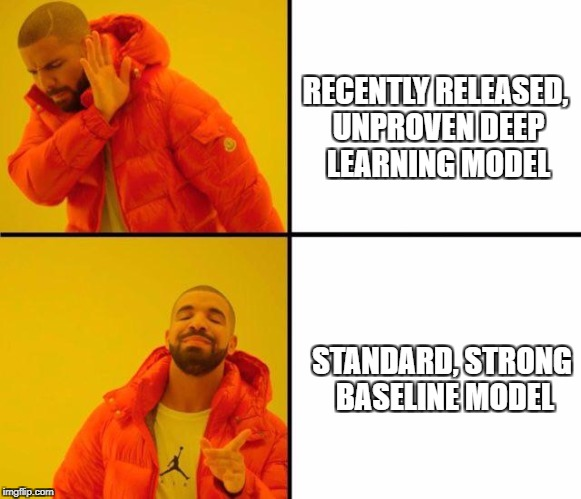

Let's have a look if "stupid" model is able to make better prediction than our method. We are going to shift the value of EURUSD change and use the value of 7 days ago to predict the value of EURUSD for tomorrow

In [ ]:
final_df_results


eurusd_close      yhat
2020-11-02      1.164212  1.134049
2020-11-03      1.164280  1.132752
2020-11-04      1.176221  1.131420
2020-11-05      1.173268  1.130057
2020-11-06      1.181754  1.128765
2020-11-09      1.189301  1.124468
2020-11-10      1.182732  1.123184
2020-11-11      1.181879  1.121960
2020-11-12      1.178030  1.120798
2020-11-13      1.180339  1.119797
2020-11-16      1.184525  1.116856
2020-11-17      1.185944  1.116160
2020-11-18      1.186366  1.115577
2020-11-19      1.184764  1.115098
2020-11-20      1.186648  1.114810
2020-11-23      1.186648  1.114075
2020-11-24      1.184273  1.114097
2020-11-25      1.190051  1.114204
2020-11-26      1.192000  1.114377
2020-11-27      1.191600  1.114694

In [ ]:
final_df_results['yhat_baselinemodel'] = final_df_results['eurusd_close'].rolling(7).mean()

Mean MAE: 0.07
MAE%: 5.60%
RMSE: 0.07
Bias: -0.07

5th percetile MAE: 0.06
25th percetile MAE: 0.06
50th percetile MAE: 0.07
75th percetile MAE: 0.07
95th percetile MAE: 0.07


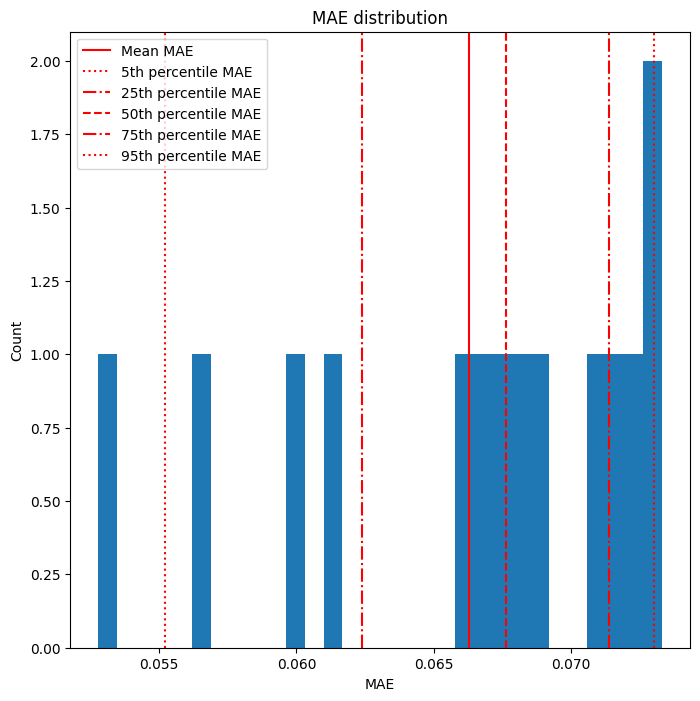

In [ ]:
# Analyze the forecast error
calc_errors(final_df_results.dropna()['yhat_baselinemodel'].values, final_df_results.dropna()['yhat'].values)


## Improve forecasting perfomances : hyperparameter tuning and extra regressors

### Load useful data

What's the influence of external forces on FOREX?

We have dowload different timeseries that could have influenced the FOREX. It's clear that the use of these regressors to improve the forecasting performances increases the complexity of the model.

i.e. Let's say that we would like to forecast FOREX in the horizon May 2021 - Jan 2022. The values of extra regressor should be known, which means that other ML models should be use to forecast for example US GDP

Here we studied the effect of GDP, inflation and consumer price index on FOREX. Raw data where download from https://fred.stlouisfed.org/

### What about COVID-19?

Is the global vaccination race the new force in FX markets? – Special Report

https://www.xm.com/is-the-global-vaccination-race-the-new-force-in-fx-markets-special-report-135646

2020 and 2021 have been affected by COVID-19 pandemic. We all know the effect of the pandemic on daily life and economics. Starting from the first days of 2021, vaccinations and growth perspective have influenced a slow restart of "normal" life and therefore of economy.

Here we explore the effect of covid and vaccinations on FOREX. Data were download from https://github.com/owid/covid-19-data

In [ ]:
# To load data from your google drive

from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Change the directory below using the one you have loaded the data in

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/colab text data for trading/2024_course

In [ ]:
df_covid = pd.read_csv('./owid-covid-data 1.csv', parse_dates=['date'])
extra_df = pd.read_csv('./extra_regressors.csv', parse_dates=['DATE'])

In [ ]:
df_covid

In [ ]:
extra_df.set_index('DATE',inplace=True)
# remap column name
map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation'}
extra_df = extra_df.rename(columns=map_dict)
# group data for each continent and sum the number of new cases
df_covid_g = df_covid.groupby(['continent','date']).agg({'new_cases':'sum'})


In [ ]:
# plot timeseries
fig, ax = plt.subplots(1,3, figsize=(20,5))
for idx, col in enumerate(extra_df):
  extra_df[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

In [ ]:
# compare Europe and North America time series
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_covid_g.loc['Europe'], label='Europe')
ax.plot(df_covid_g.loc['North America'], label='North America')
fig.legend()

### Timeseries correlation

# TASK 1: merge EURUSD data with external regressors and evaluate correlation.
Since you cannot use unavailable data for your prediction, shift all external regressor by two weeks so that you are sure you have all data available

### Forecasting using extra regressors with Prophet

# TASK 2: create a new model that exploits external regressors.
* Use function addregressor() to add your regressors and train a new model.
* Explore the usage of from prophet.diagnostics import cross_validation function.
* Create a cross validation experiment with cutoffs of the last 30 steps with initial='1119 days', period='1 days', horizon = '5 days'.
* test on the test dataset as before and evaluate performance metrics

# TASK 3: Can you think at other useful external regressors?
Find new data, add them and test their efficacy